**What this file does?**

You can plot your Linear Problems and check their Optimal solutions, included data about vertexes about feasible region.

**Instructions for use:**

It is reccommended to open the file with Colab or Jupyter.

Once run it will ask to type step by step the data of the LP like: coefficients values, number of constraints, sense of the optimization of the problem etc. A message with an example will be shown step by step.

After type such values is needed to press enter.

Enter the coefficients of the objective function separated by a comma (e.g., 60,40): 2,1
Enter 'maximize' if you want to maximize or 'minimize' if you want to minimize: maximize
Enter the number of constraints: 4
Enter the coefficients of constraint 1 separated by a comma (e.g., 10,10): 6,3
Enter the relationship of constraint 1 (<=, >=, =): >=
Enter the value of the right-hand side of constraint 1: 450
Enter the coefficients of constraint 2 separated by a comma (e.g., 10,10): 6,3
Enter the relationship of constraint 2 (<=, >=, =): <=
Enter the value of the right-hand side of constraint 2: 480
Enter the coefficients of constraint 3 separated by a comma (e.g., 10,10): 2,4
Enter the relationship of constraint 3 (<=, >=, =): >=
Enter the value of the right-hand side of constraint 3: 450
Enter the coefficients of constraint 4 separated by a comma (e.g., 10,10): 2,4
Enter the relationship of constraint 4 (<=, >=, =): <=
Enter the value of the right-hand side of constraint 4: 480

Linear Pro

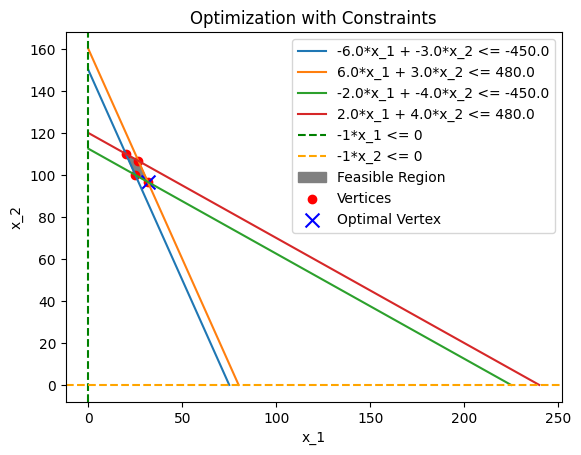

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.optimize import linprog

# Function to input and return coefficients of the objective function
def get_objective_function():
    obj_coeff_str = input("Enter the coefficients of the objective function separated by a comma (e.g., 60,40): ")
    obj_coeffs = np.array([float(coeff) for coeff in obj_coeff_str.split(',')])
    return obj_coeffs

# Function to input and return the optimization sense (maximize or minimize)
def get_optimization_sense():
    optimization_sense = input("Enter 'maximize' if you want to maximize or 'minimize' if you want to minimize: ").lower()
    while optimization_sense not in ['maximize', 'minimize']:
        print("Invalid input. Please enter 'maximize' or 'minimize'.")
        optimization_sense = input("Enter 'maximize' if you want to maximize or 'minimize' if you want to minimize: ").lower()
    return optimization_sense

# Function to input and return constraints in the form of coefficients, sense, and right-hand side
def get_constraints():
    num_constraints = int(input("Enter the number of constraints: "))
    constraints = []

    for i in range(num_constraints):
        coeff_str = input(f"Enter the coefficients of constraint {i+1} separated by a comma (e.g., 10,10): ")
        coeff = np.array([float(c) for c in coeff_str.split(',')])
        sense = input(f"Enter the relationship of constraint {i+1} (<=, >=, =): ")
        while sense not in ['<=', '>=', '=']:
            print("Invalid input. Please enter '<=', '>=', or '='.")
            sense = input(f"Enter the relationship of constraint {i+1} (<=, >=, =): ")
        rhs = float(input(f"Enter the value of the right-hand side of constraint {i+1}: "))
        constraints.append((coeff, sense, rhs))

    return constraints

# Function to print the linear programming problem (objective function and constraints)
def print_linear_program(obj_coeffs, optimization_sense, constraints):
    print("="*20)
    print("\nLinear Programming Problem:")

    # Objective Function
    print("\nObjective Function:")
    print(f"Maximize: Z = " if optimization_sense == 'maximize' else "Minimize: Z = ", end="")
    print(f"{obj_coeffs[0]} * x_1 + {obj_coeffs[1]} * x_2")

    # Constraints
    print("\nConstraints:")
    for i, (coeff, sense, rhs) in enumerate(constraints):
        print(f"{coeff[0]} * x_1 + {coeff[1]} * x_2 {sense} {rhs}")

    # Non-negativity Constraints
    print("\nNon-negative Constraints:")
    print("x_1 >= 0")
    print("x_2 >= 0")

    print("\n="+"="*19)

# Function to standardize constraints to the form Ax <= b
def standardize_constraints(constraints):
    for i, (coeff, sense, rhs) in enumerate(constraints):
        if sense == '>=':
            constraints[i] = (-coeff, '<=', -rhs)
        elif sense == '=':
            constraints[i] = (coeff, '<=', rhs)

# Function to calculate feasible region vertices and objective values
def calculate_vertices(obj_coeffs, optimization_sense, constraints):
    vertices = []
    obj_values = []

    for i in range(len(constraints)):
        for j in range(i + 1, len(constraints)):
            coeff_i, _, rhs_i = constraints[i]
            coeff_j, _, rhs_j = constraints[j]

            intersection = find_intersection(coeff_i, rhs_i, coeff_j, rhs_j)

            if intersection is not None and is_valid_vertex(intersection, constraints):
                vertices.append(intersection)

    for coeff, _, rhs in constraints:
        if coeff[1] != 0:
            intersection_x2 = [0, rhs / coeff[1]]
            if is_valid_vertex(intersection_x2, constraints):
                vertices.append(intersection_x2)

    for vertex in vertices:
        obj_value = np.dot(obj_coeffs, vertex)
        obj_values.append(obj_value)

    if optimization_sense == 'maximize':
        max_index = np.argmax(obj_values)
    else:
        max_index = np.argmin(obj_values)

    return vertices, obj_values, max_index

# Function to find the intersection point of two constraint lines
def find_intersection(coeff1, rhs1, coeff2, rhs2):
    A = np.array([coeff1[:2], coeff2[:2]])
    b = np.array([rhs1, rhs2])

    try:
        intersection = np.linalg.solve(A, b)
        return intersection
    except np.linalg.LinAlgError:
        return None

# Function to check if a vertex is valid (satisfies all constraints)
def is_valid_vertex(vertex, constraints):
    for coeff, _, rhs in constraints:
        if np.dot(coeff, vertex) > rhs:
            return False
    return True

# Function to print coordinates of feasible region vertices
def print_vertices_and_objective_values(vertices, obj_coeffs, constraints):
    print("\nCoordinates of Feasible Region Vertices:")
    unique_vertices = set()

    for i, vertex in enumerate(vertices, start=1):
        if is_valid_vertex(vertex, constraints) and vertex[0] >= 0 and vertex[1] >= 0:
            unique_vertices.add(tuple(np.round(vertex, decimals=8)))

    for i, vertex in enumerate(unique_vertices, start=1):
        obj_value = np.dot(obj_coeffs, np.array(vertex))
        print(f"Vertex {i}: {np.array(vertex)}, Objective Function Value: {obj_value}")

# Function to check and print optimal solutions
def check_solutions(obj_values, optimization_sense, vertices, obj_coeffs, constraints):
    print("\n="+"="*19)

    max_obj_value = None

    if optimization_sense == 'maximize':
        max_obj_value = max(obj_values, default=None)
    else:
        max_obj_value = min(obj_values, default=None)

    stored_data = []
    unique_vertices = set()

    for i in range(len(vertices)):
        if np.isclose(obj_values[i], max_obj_value) and is_valid_vertex(vertices[i], constraints):
            vertex_tuple = tuple(vertices[i])
            if vertex_tuple not in unique_vertices:
                unique_vertices.add(vertex_tuple)
                stored_data.append({'Vertex': vertices[i], 'Objective Value': obj_values[i]})

    optimal_solutions = []  # Initialize here

    if len(stored_data) == 2 and np.isclose(stored_data[0]['Objective Value'], stored_data[1]['Objective Value']):
        print("The problem has two equal optimum values found.")
        for solution in stored_data:
            print(f"Vertex: {solution['Vertex']}, Objective Value: {solution['Objective Value']}")
    elif max_obj_value is not None:
        print("The problem has one possible solution.")
        print(f"Optimal Objective Value: {max_obj_value}")

        optimal_solutions = [
            {'Vertex': solution['Vertex'], 'Objective Value': solution['Objective Value']}
            for solution in stored_data
        ]

        if optimal_solutions:
            print(f"Optimal Solution: {optimal_solutions[0]['Vertex']}")
        else:
            print("The problem has infinite solutions.")

    else:
        raise SolutionNotFoundError("No possible solutions for the problem.")  # Raise the exception here

    return optimal_solutions if max_obj_value is not None else None

# Function to check if a vertex is in the feasible region
def is_vertex_in_feasible_region(vertices, constraints):
    return np.array([is_valid_vertex(vertex, constraints) and vertex[0] >= 0 and vertex[1] >= 0 for vertex in vertices])

# Function to plot the feasible region using Matplotlib and SciPy
def plot_with_scipy(obj_coeffs, optimization_sense, constraints, vertices, obj_values, max_index):
    all_vertices = np.array(vertices)

    fig, ax = plt.subplots()

    for coeff, sense, rhs in constraints:
        if not np.array_equal(coeff, [0, 0]):
            if coeff[1] == 0:
                # Vertical line
                x_value = rhs / coeff[0]
                ax.axvline(x=x_value, linestyle='--', color='green', label=f"{coeff[0]}*x_1 {sense} {rhs}")
            elif coeff[0] == 0:
                # Horizontal line
                y_value = rhs / coeff[1]
                ax.axhline(y=y_value, linestyle='--', color='orange', label=f"{coeff[1]}*x_2 {sense} {rhs}")
            else:
                x_values = np.linspace(0, max(10, rhs / coeff[0]), 100)
                y_values = (-coeff[0] * x_values + rhs) / coeff[1]
                mask = (y_values >= 0) & (x_values >= 0)
                ax.plot(x_values[mask], y_values[mask], label=f"{coeff[0]}*x_1 + {coeff[1]}*x_2 {sense} {rhs}")

    valid_vertices = all_vertices[is_vertex_in_feasible_region(all_vertices, constraints)]

    if len(valid_vertices) >= 3:
        # Perturb the points used in constructing the convex hull
        hull = plt.Polygon(valid_vertices[ConvexHull(valid_vertices + np.random.normal(0, 1e-8, size=(len(valid_vertices), 2))).vertices],
                           closed=True, edgecolor='gray', facecolor='gray', label='Feasible Region')
        ax.add_patch(hull)

    ax.scatter(valid_vertices[:, 0], valid_vertices[:, 1], marker='o', color='red', label='Vertices')

    extreme_vertex = valid_vertices[max_index]
    ax.scatter(extreme_vertex[0], extreme_vertex[1], marker='x', color='blue', s=100, label='Optimal Vertex')

    ax.legend()
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_title('Optimization with Constraints')

    plt.show()

# Custom exception for when no solution is found
class SolutionNotFoundError(Exception):
    pass

# Main function to orchestrate the entire process
def main():
    obj_coeffs = get_objective_function()
    optimization_sense = get_optimization_sense()
    constraints = get_constraints()

    # Print Linear Programming Problem
    print_linear_program(obj_coeffs, optimization_sense, constraints)

    constraints.extend([(np.array([-1, 0]), '<=', 0), (np.array([0, -1]), '<=', 0)])

    standardize_constraints(constraints)

    vertices, obj_values, max_index = calculate_vertices(obj_coeffs, optimization_sense, constraints)
    print_vertices_and_objective_values(vertices, obj_coeffs, constraints)

    try:
        check_solutions(obj_values, optimization_sense, vertices, obj_coeffs, constraints)
        plot_with_scipy(obj_coeffs, optimization_sense, constraints, vertices, obj_values, max_index)
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()
